# Testing Internet Speed
It might be of interest to see how internet speed varies throughout the day, its consistency, and how it is affected by other processes.

In [1]:
## Importing & function definition
import speedtest # pip install speedtest-cli
import pandas as pd
import time
from IPython.display import clear_output
from drawnow import drawnow, figure
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates

# Get the speedtest results in a dict
def getResults(servers=[], threads=None):
    print('Connecting to best server ...')
    s = speedtest.Speedtest()
    s.get_servers(servers)
    s.get_best_server()
    print('Testing download speed ...')
    s.download(threads=threads)
    print('Testing upload speed ...')
    s.upload(threads=threads)    
    print('Test completed.')
    results_dict = s.results.dict()
    return results_dict

# Define plotting function so that the plot can be refreshed in a notebook
def drawFig():    
    _, ax = plt.subplots()
    figure()
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.plot(df['timestamp'], df['download']/1e6, 'bo-', label='Download')
    ax.plot(df['timestamp'], df['upload']/1e6, 'gx-', label='Upload')
    ax.set(xlabel='Time', ylabel='Internet Speed (Mb/s)')
    ax.legend()         
    plt.show()


## Periodically testing the down/upload speed
Set a duration and frequency for sampling the data, and plot the speeds as a function of time. Shown are the speeds for a 2-hour window. Significant dropouts could correspond to concurrent usage of applications that use non-trivial bandwidth (such as video streaming).

<Figure size 432x288 with 0 Axes>

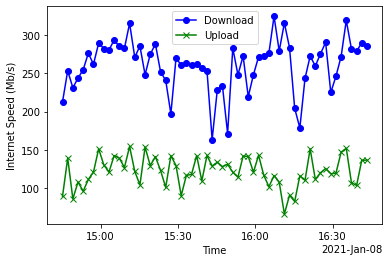

<Figure size 432x288 with 0 Axes>

Time elapsed: 20.33486


In [2]:
## Actually doing the job

# Identify desired data to store from results
desired_cols = ['download', 'upload', 'ping', 'timestamp', 'bytes_sent', 'bytes_received']
server_cols = ['url', 'lat', 'lon', 'name', 'sponsor', 'id', 'host', 'd', 'latency']

# Initialize the dict lists
results_dicts = []
server_dicts = []

# Set frequency  & duration 
freq = 30 # samples per hour
dur = 2 # in hours

N = round(freq*dur)
for _ in range(N):
    # Time start
    t_start = dt.datetime.now()

    # Get the results
    results_dict = getResults()
    server_dict = results_dict['server']

    # Show results
    print(results_dict)

    # Append results to storage list
    results_dicts.append(results_dict)
    server_dicts.append(server_dict)

    # Convert dict-lists into dataframes
    df_info = pd.DataFrame(results_dicts, columns=desired_cols)
    df_server = pd.DataFrame(server_dicts, columns=server_cols).add_prefix('server_')

    # Combine into one data frame
    df = pd.concat([df_info, df_server], axis=1)
    df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_convert('US/Eastern').dt.tz_localize(None)
    
    # Show current dataframe
    clear_output()   
    drawnow(drawFig) 

    # Time finish
    t_end = dt.datetime.now()
    time_delta = (t_end - t_start).total_seconds()

    # Print time-elapsed 
    print('Time elapsed: ' + str(time_delta))

    # Wait until next sampling time
    time.sleep(max(0,60*60/freq - (time_delta)))

tdy = str(dt.date.today()).replace('-', '_')
df.to_csv(tdy+'_speedtest.csv')